In [3]:
%matplotlib inline

# Packages
import os, glob, scipy, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Project directory
base_dir = os.path.realpath('..')
print(base_dir)

# Project-specific functions
funDir = os.path.join(base_dir,'Code/Functions')
print(funDir)
sys.path.append(funDir)
import choiceModels, costFunctions, penalizedModelFit, simulateModel

# General-use python functions
dbPath = '/'.join(base_dir.split('/')[0:4])
sys.path.append('%s/Python'%dbPath)
import FigureTools

/Users/jeroen/Dropbox (Brown)/PhD/0. Working folder/HMTG_followUp_final/ShareDataCode
/Users/jeroen/Dropbox (Brown)/PhD/0. Working folder/HMTG_followUp_final/ShareDataCode/Code/Functions


## Define simulations

In [13]:
# Create theta-phi space
decimals = int(np.log10(precision)+1)
if model == 'MP_ppSOE':
    phi = np.around(np.arange(-0.1,0.10001,0.2/precision).astype('float'),decimals=decimals)#[-.1,0,.1]
    theta = np.around(np.arange(0,.50001,.5/precision).astype('float'),decimals=decimals)#[0,.1,.2,.3,.4,.5,.6]
    phiLen = len(phi)
    thetaLen = len(theta)
    phi[np.floor(len(phi)/2).astype(int)]=0
    thetaPhi = np.repeat(theta,phiLen)
    thetaPhi = pd.DataFrame(thetaPhi)
    thetaPhi.columns = ['theta']
    thetaPhi['phi'] = np.tile(phi,thetaLen)
    print (len(thetaPhi))
    print (thetaPhi.head())

10201
   theta    phi
0    0.0 -0.100
1    0.0 -0.098
2    0.0 -0.096
3    0.0 -0.094
4    0.0 -0.092


## Study 1

In [21]:
def simulate_data(model = 'MP_ppSOE',theta=-99, phi=-99,multipliers = [2,4,6],investments=np.arange(1,11)):
    modelDict = {'MP':choiceModels.MP_model,'IA':choiceModels.IA_model,
                 'GA':choiceModels.GA_model,'GR':choiceModels.GR_model,
                'MP_ppSOE':choiceModels.MP_model_ppSOE, 'GA_ppSOE':choiceModels.GA_model_ppSOE}
    baseMult = multipliers[1]
    simulations = pd.DataFrame(columns=['model','inv','mult','baseMult','exp','ret','theta','phi'])
    for mult in multipliers:
        for inv in investments:
            exp = baseMult/2*inv
#             exp = np.maximum(.5*(10-inv+inv*baseMult)-(10-inv),0)
            ret = modelDict[model](inv,mult,baseMult,exp,theta,phi)
            simulations = simulations.append(pd.DataFrame(
                [[model,inv,mult,baseMult,exp,ret,theta,phi]],
                columns=simulations.columns))
    return simulations

In [7]:
study = 1
model = 'MP_ppSOE'
precision = 100

In [8]:
dat = pd.read_csv(os.path.join(base_dir,'Data/Study1/HMTG/allDataLong.csv'),header=None,index_col=None)
dat.columns = ['sub','block','trial','inv','baseMult','mult','exp','ret']
dat = dat.loc[dat['inv']>0,:]
dat.head()

,sub,block,trial,inv,baseMult,mult,exp,ret
0,1,1,1,9,4,4,18,18
1,1,1,2,6,4,6,10,10
2,1,1,3,4,4,4,5,4
3,1,1,4,5,4,2,8,2
4,1,1,5,3,4,6,2,3


/Users/jeroen/anaconda3/envs/hmtg_fu/lib/python3.8/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


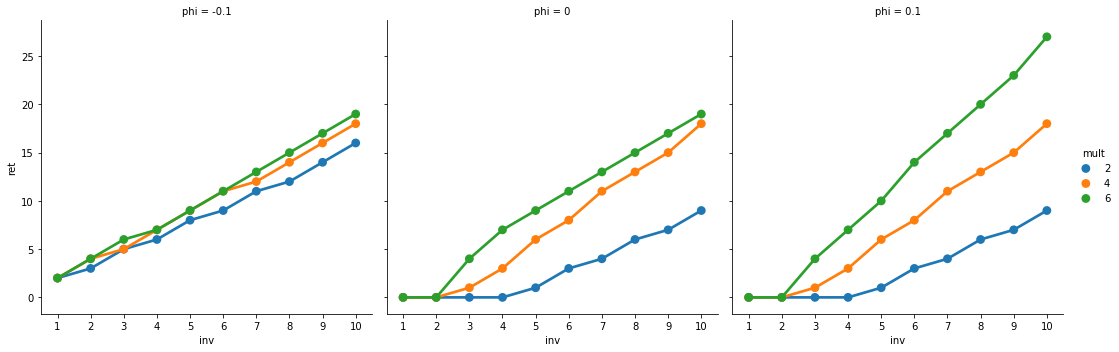

In [9]:
# Test
theta = .1
model = 'MP_ppSOE'
sims = simulate_data(model=model,theta=theta,phi=.1).append(simulate_data(model=model,theta=theta,phi=0)
        ).append(simulate_data(model=model,theta=theta,phi=-.1))
sns.factorplot(data=sims,x='inv',y='ret',hue='mult',col='phi')

In [11]:
# Run simulations
for baseMult in [4,6]:
    trialSet = dat.loc[(dat['sub']==1) & (dat['baseMult']==baseMult),['inv','baseMult','mult']]
    trialSet = trialSet.sort_values(by=['mult','inv'])
    print (trialSet.shape)
    multipliers = np.unique(trialSet['mult'])
    investments = np.unique(trialSet['inv'])
    print (investments,multipliers)
    simulations_short = np.zeros((len(thetaPhi),30))
    simulations_long = np.zeros((len(thetaPhi),trialSet.shape[0]))
    for i in range(len(thetaPhi)):
        if np.mod(i,precision)==0:
            print (i),
        theta = thetaPhi.iloc[i,0]
        phi = thetaPhi.iloc[i,1]
        singleSim = simulate_data(model=model,theta=theta,phi=phi,multipliers=multipliers,investments=investments)
        simulations_short[i,:] = singleSim['ret']
        simulations_long[i,:] = trialSet.merge(singleSim,on=['inv','mult'])['ret'] # Expand to full trial set
    print ('')
    print (simulations_short.shape)
    print (simulations_long.shape)

    pd.DataFrame(simulations_short).to_csv(base_dir +
            '/Data/Study%i/ComputationalModel/Simulations-short_study-%i_baseMult-%i_model-%s_precision-%i.csv'%(
                study,study,baseMult,model,precision))
    pd.DataFrame(simulations_long).to_csv(base_dir +
            '/Data/Study%i/ComputationalModel/Simulations/Simulations-long_study-%i_baseMult-%i_model-%s_precision-%i.csv'%(
                study,study,baseMult,model,precision))

(76, 3)
[ 1  2  3  4  5  6  7  8  9 10] [2 4 6]
0

(10201, 30)
(10201, 76)
(76, 3)
[ 1  2  3  4  5  6  7  8  9 10] [4 6 8]
0

(10201, 30)
(10201, 76)


## Study 2

In [19]:
def simulate_data(model = 'MP',theta=-99, phi=-99,multipliers = [2,4,6],investments=np.arange(1,11)):
    modelDict = {'MP':choiceModels.MP_model,'IA':choiceModels.IA_model,
                 'GA':choiceModels.GA_model,'GR':choiceModels.GR_model,
                'MP_ppSOE':choiceModels.MP_model_ppSOE, 'GA_ppSOE':choiceModels.GA_model_ppSOE}
    mult = multipliers[1]
    simulations = pd.DataFrame(columns=['model','inv','mult','belMult','exp','ret','theta','phi'])
    for belMult in multipliers:
        for inv in investments:
            exp = belMult/2*inv
            ret = modelDict[model](inv,mult,belMult,exp,theta,phi)
            simulations = simulations.append(pd.DataFrame(
                [[model,inv,mult,belMult,exp,ret,theta,phi]],
                columns=simulations.columns))
    return simulations

In [10]:
study = 2
model = 'MP_ppSOE'
precision = 100

In [15]:
dat = pd.read_csv(os.path.join(base_dir,'Data/Study2/HMTG/allDataLong.csv'),header=0,index_col=0)
dat = dat.loc[dat['inv']>0,:]
dat.head()

,sub,trial,inv,mult,belMult,ret,exp
1,152,1,1,4,2,0.0,0.0
2,152,2,4,4,4,5.0,5.0
3,152,3,2,4,2,0.0,0.0
4,152,4,10,4,2,10.0,10.0
5,152,5,6,4,2,8.0,4.0


In [20]:
# Run simulations
trialSet = dat.loc[(dat['sub']==152),['inv','belMult']]
trialSet = trialSet.sort_values(by=['belMult','inv'])
print (trialSet.shape)
multipliers = np.unique(trialSet['belMult'])
investments = np.unique(trialSet['inv'])
print (investments,multipliers)
simulations_short = np.zeros((len(thetaPhi),30))
simulations_long = np.zeros((len(thetaPhi),trialSet.shape[0]))
for i in range(len(thetaPhi)):
    if np.mod(i,100)==0:
        print (i),
    theta = thetaPhi.iloc[i,0]
    phi = thetaPhi.iloc[i,1]
    singleSim = simulate_data(model=model,theta=theta,phi=phi,multipliers=multipliers,investments=investments)
    simulations_short[i,:] = singleSim['ret']
    simulations_long[i,:] = trialSet.merge(singleSim,on=['inv','belMult'])['ret'] # Expand to full trial set
print ('')
print (simulations_short.shape)
print (simulations_long.shape)

(76, 2)
[ 1  2  3  4  5  6  7  8  9 10] [2 4 6]
0

(10201, 30)
(10201, 76)


In [ ]:
pd.DataFrame(simulations_short).to_csv(base_dir +
            '/Data/Study2/ComputationalModel/Simulations-short_study-2_model-%s_precision-%i.csv'%(model,precision))
pd.DataFrame(simulations_long).to_csv(base_dir +
            '/Data/Study2/ComputationalModel/Simulations-long_study-2_model-%s_precision-%i.csv'%(model,precision))